<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com) for PyCon 2015. Source and license info is on [GitHub](https://github.com/jakevdp/sklearn_pycon2015/).</i></small>

# Supervised Learning In-Depth: Support Vector Machines

Previously we introduced supervised machine learning.
There are many supervised learning algorithms available; here we'll go into brief detail one of the most powerful and interesting methods: **Support Vector Machines (SVMs)**.

In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.core.display import Image, display

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Motivating Support Vector Machines

Support Vector Machines (SVMs) are a supervised learning algorithm which can be used for **classification** or **regression**. SVMs are a **discriminative** classifier: that is, they draw a boundary between clusters of data.

Here's a quick example of support vector classification. First we need to create a dataset:

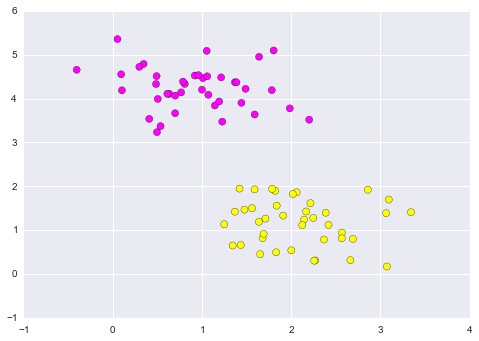

In [14]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=80, centers=2,
                  random_state=0, cluster_std=0.54)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring');

Our discriminative classifier attempts to draw a line between the two sets of data. 
BUT! There are many possible lines! (i.e the problem/line is ill-posed)! For example, we could come up with several possibilities which perfectly discriminate between the classes in this example:

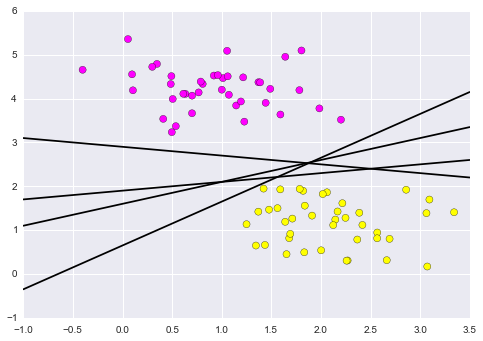

In [15]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9), (0.2, 1.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are *very* different separaters which perfectly discriminate between these samples. Depending on which you choose, a new data point could be classified entirely differently!

How can we improve on this?

### Support Vector Machines: Maximizing the *Margin*

Support vector machines are one way to address this.
What support vector machined do is to not only draw a line, but consider a *region* about the line of some given width, so as to maximize the **margin/distance**.  Here's an example of what it might look like:

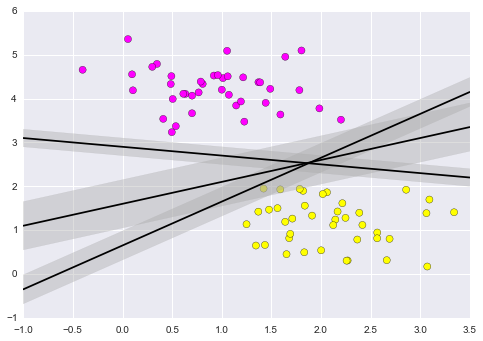

In [16]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none', color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

Notice here that if we want to maximize this width, the middle fit is clearly the best.
This is the intuition of **support vector machines**, which optimize a linear discriminant model in conjunction with a **margin** representing the perpendicular distance between the datasets.

#### Fitting a Support Vector Machine

Now we'll fit a Support Vector Machine Classifier to these points. While the  details of the likelihood model are interesting, we'll let you read about those elsewhere. 
Instead, we'll just treat the scikit-learn implementation as a **black box** which accomplishes the above task.

In [23]:
from sklearn.svm import SVC # "Support Vector Classifier"
clf = SVC(kernel='linear')
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

To better visualize what's happening, here's a quick convenience function that will plot SVM decision boundary:

In [24]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

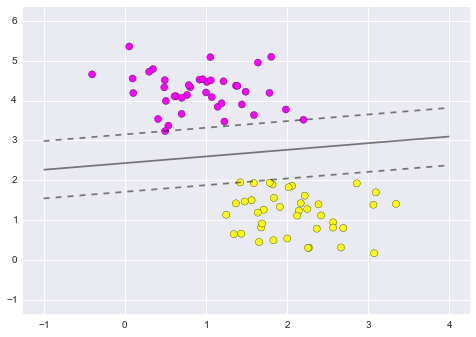

In [25]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf);

Notice that the dashed lines touch a couple of the points: these points are the pivotal pieces of this fit, and are known as the **support vectors** (giving the algorithm its name).
These are stored in the ``support_vectors_`` attribute of the classifier:

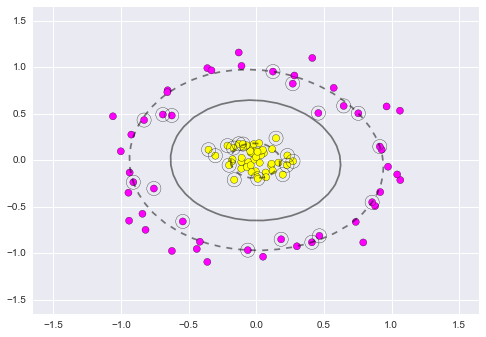

In [35]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');

Let's use IPython's ``interact`` functionality to explore how the distribution of points affects the support vectors and the discriminative fit.
(This is only available in IPython 2.0+, and will not work in a static view)

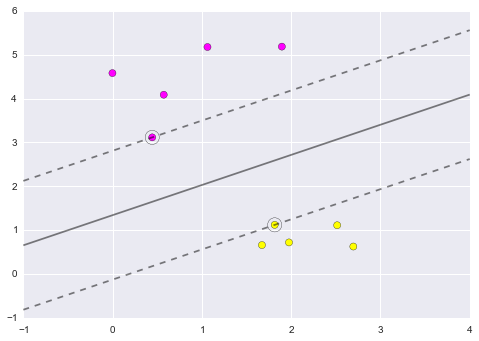

In [36]:
from IPython.html.widgets import interact

def plot_svm(N=10):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    clf = SVC(kernel='linear')
    clf.fit(X, y)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
    plt.xlim(-1, 4)
    plt.ylim(-1, 6)
    plot_svc_decision_function(clf, plt.gca())
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=200, facecolors='none')
    
interact(plot_svm, N=[10, 200], kernel='linear');

Notice the unique thing about SVM is that only the support vectors matter: that is, if you moved any of the other points without letting them cross the decision boundaries, they would have no effect on the classification results!

#### Going further: Kernel Methods

Where SVM gets really exciting is when used in conjunction with *kernels*.
In brief, Kernels map the data into a higher dimensional space, where it may be easier to classify/discriminate.

To motivate the need for kernels, let's look at some data which is not linearly separable:

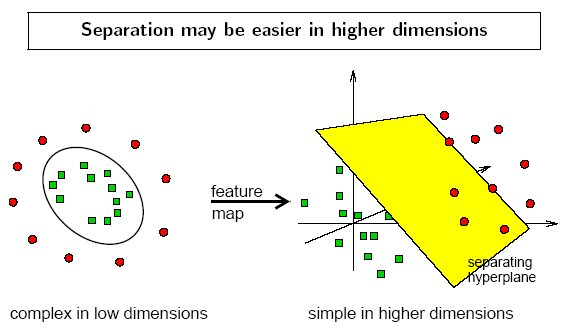

In [37]:
display(Image(filename='images/kernel-SvmDimensionMap.jpg'))

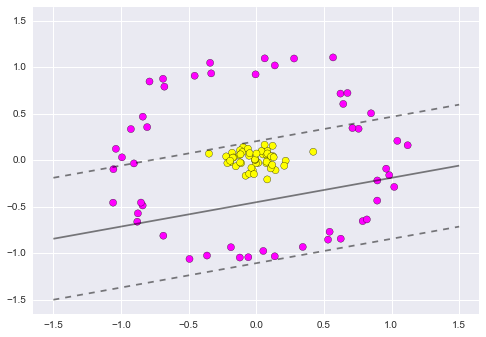

In [38]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf);

Clearly, a simple linear line won't be able to  separate this data.
One solution is to apply a **kernel**, which is some functional transformation of the input data. 

For example, one useful model we can use is a **radial basis function** (RBF)

In [39]:
r = np.exp(-(X[:, 0] ** 2 + X[:, 1] ** 2))

If we plot this along with our data, we can see the effect of it:

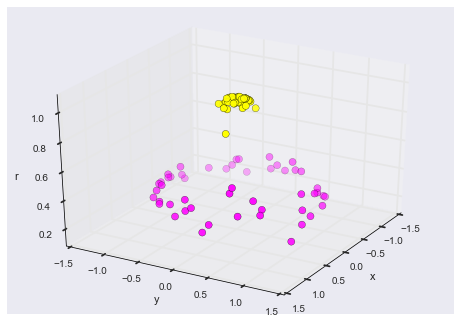

In [40]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='spring')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180));

We can see that with this additional dimension, the data becomes trivially linearly separable!
SVM has a better version of this kernel built-in. This is accomplished by using ``kernel='rbf'``, short for *radial basis function*:

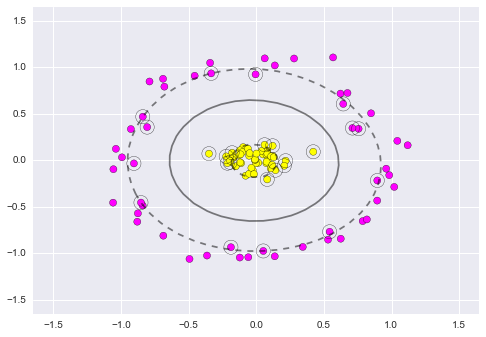

In [41]:
clf = SVC(kernel='rbf')
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');

We'll leave SVMs and take a look at another classification algorithm (*my favorite!*): **Random Forests**.